In [1]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from src.models.model_selection import GridSearch, FeatureSelection
from src.models.classification import Classification

In [2]:
# read config
with open('config.yml', 'r') as file:
    config=yaml.load(file, Loader= yaml.SafeLoader)
del file

In [3]:
# load data
df = pd.read_csv(config['data_loader']['path'])
display(df.head())

# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:,1:-1], df['Class']
    , test_size=config['model_selection']['test_set_size']
    , random_state=123
    , shuffle=True
    )

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [4]:
grid_search = GridSearch(model_selection=config['model_selection'])
grid_search.fit(X=X_train, y=y_train)

c:\Users\gonpr\ML_Projects\Fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\gonpr\ML_Projects\Fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

In [5]:
# greedy feature selection
clf=Classification(
    algorithm=grid_search.best_algorithm
    , **grid_search.best_hyperparams
    )
feature_selection = FeatureSelection(X=X_train, y=y_train)
feature_selection.wrapper(clf=clf, model_selection=config['model_selection']
)

# should feature selection be done before or after model selection?
# should it be trained on different dataset?

c:\Users\gonpr\ML_Projects\Fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\gonpr\ML_Projects\Fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Index(['V4', 'V12', 'V14'], dtype='object')

In [6]:
# fit best algorithm on most important features of training data 
clf = clf=Classification(
    algorithm=grid_search.best_algorithm
    , **grid_search.best_hyperparams
    )
clf.fit(X=X_train.iloc[100000:, :], y=y_train.iloc[100000:,])
# predict target value for the test set
y_pred = clf.predict(X_test)
y_score = clf.score(X_test)[:, -1]

c:\Users\gonpr\ML_Projects\Fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
from src.models.model_selection import ClassificationThreshold

tuned_clf = ClassificationThreshold(model_selection=config['model_selection'])
tuned_clf.fit(clf=clf, X=X_train.iloc[:100000, :], y=y_train.iloc[:100000,])

c:\Users\gonpr\ML_Projects\Fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\gonpr\ML_Projects\Fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

np.float64(0.4545454545376217)

'\nhttps://medium.com/towards-data-science/tune-in-decision-threshold-optimization-with-scikit-learns-tunedthresholdclassifiercv-7de558a2cf58\nhttps://scikit-learn.org/stable/auto_examples/model_selection/plot_cost_sensitive_learning.html#tunedthresholdclassifiercv-no-cv\nhttps://scikit-learn.org/stable/modules/classification_threshold.html\n'

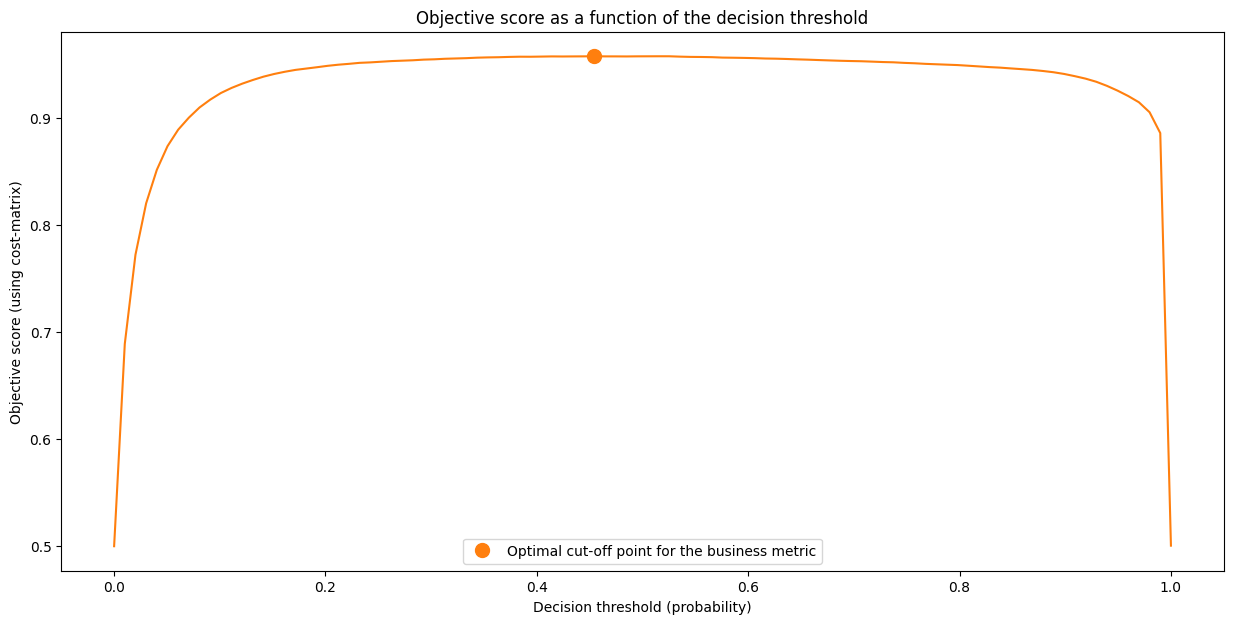

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axs.plot(
        tuned_clf.model.cv_results_["thresholds"],
        tuned_clf.model.cv_results_["scores"],
        color="tab:orange",
    )
axs.plot(
    tuned_clf.model.best_threshold_,
    tuned_clf.model.best_score_,
    "o",
    markersize=10,
    color="tab:orange",
    label="Optimal cut-off point for the business metric",
)
axs.legend()
axs.set_xlabel("Decision threshold (probability)")
axs.set_ylabel("Objective score (using cost-matrix)")
axs.set_title("Objective score as a function of the decision threshold")
"""
https://medium.com/towards-data-science/tune-in-decision-threshold-optimization-with-scikit-learns-tunedthresholdclassifiercv-7de558a2cf58
https://scikit-learn.org/stable/auto_examples/model_selection/plot_cost_sensitive_learning.html#tunedthresholdclassifiercv-no-cv
https://scikit-learn.org/stable/modules/classification_threshold.html
"""

In [9]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.metrics import confusion_matrix

pos_label, neg_label = y_train.unique()

def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr

tpr_score = recall_score  # TPR and recall are the same metric
scoring = {
    "precision": make_scorer(precision_score, pos_label=pos_label),
    "recall": make_scorer(recall_score, pos_label=pos_label),
    "fpr": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr": make_scorer(tpr_score, pos_label=pos_label),
}

def plot_roc_pr_curves(vanilla_model, tuned_model, *, title):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

    linestyles = ("dashed", "dotted")
    markerstyles = ("o", ">")
    colors = ("tab:blue", "tab:orange")
    names = ("Vanilla GBDT", "Tuned GBDT")
    for idx, (est, linestyle, marker, color, name) in enumerate(
        zip((vanilla_model, tuned_model), linestyles, markerstyles, colors, names)
    ):
        decision_threshold = getattr(est, "best_threshold_", 0.5)
        PrecisionRecallDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[0],
            name=name,
        )
        axs[0].plot(
            scoring["recall"](est, X_test, y_test),
            scoring["precision"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )
        RocCurveDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[1],
            name=name,
            plot_chance_level=idx == 1,
        )
        axs[1].plot(
            scoring["fpr"](est, X_test, y_test),
            scoring["tpr"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )

    axs[0].set_title("Precision-Recall curve")
    axs[0].legend()
    axs[1].set_title("ROC curve")
    axs[1].legend()

    axs[2].plot(
        tuned_model.cv_results_["thresholds"],
        tuned_model.cv_results_["scores"],
        color="tab:orange",
    )
    axs[2].plot(
        tuned_model.best_threshold_,
        tuned_model.best_score_,
        "o",
        markersize=10,
        color="tab:orange",
        label="Optimal cut-off point for the business metric",
    )
    axs[2].legend()
    axs[2].set_xlabel("Decision threshold (probability)")
    axs[2].set_ylabel("Objective score (using cost-matrix)")
    axs[2].set_title("Objective score as a function of the decision threshold")
    fig.suptitle(title)

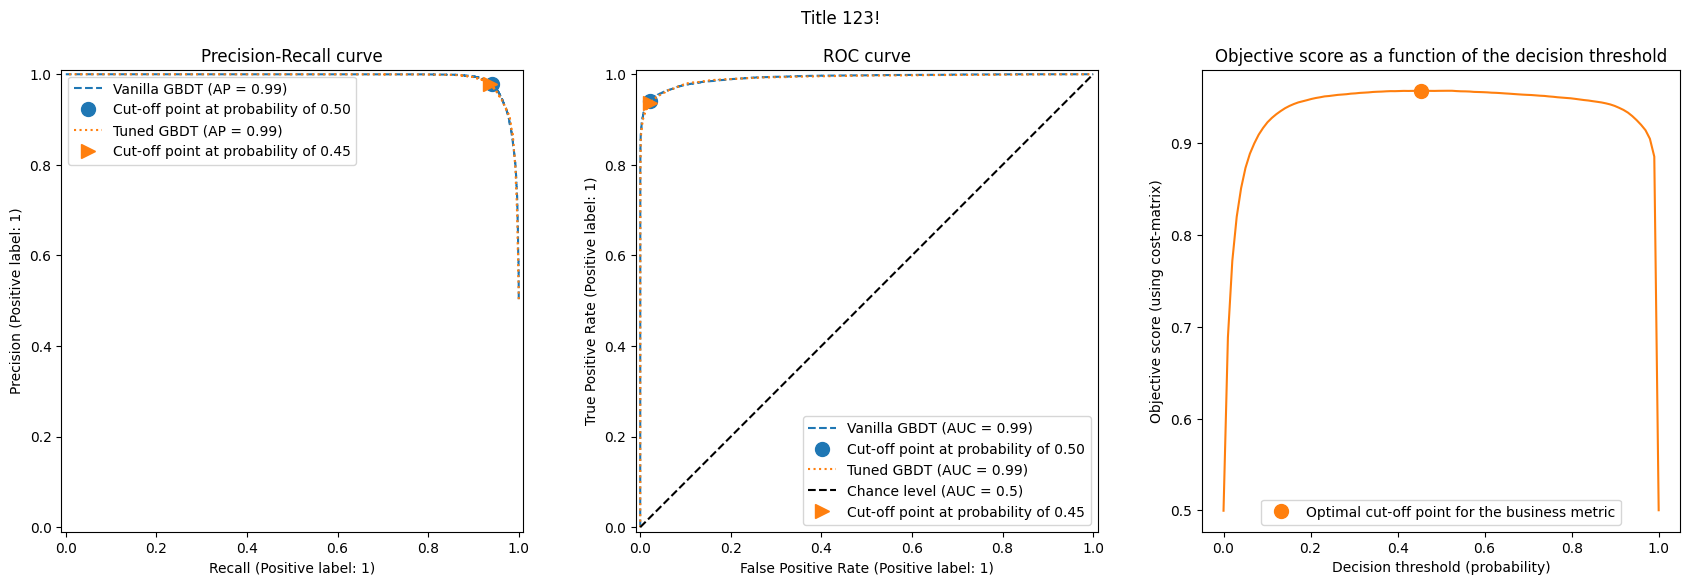

In [10]:
title = "Title 123!"
plot_roc_pr_curves(clf.model, tuned_clf.model, title=title)

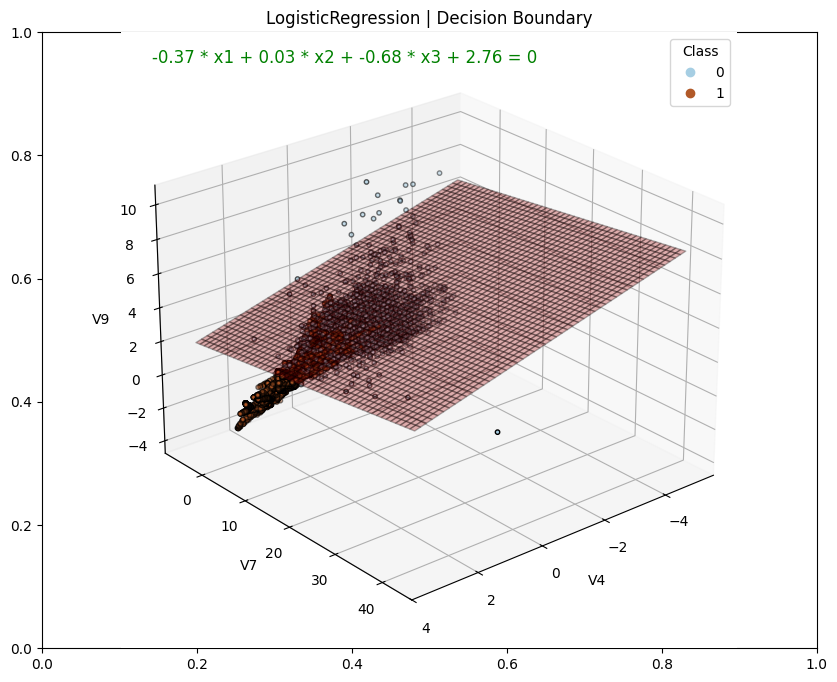

In [11]:
from src.visuals.boundary import plot_boundary

plot_boundary(
    X=X_test.iloc[:,[3,6,8]], y=y_test, clf=clf, azim=50, plot_points=True
)

In [ ]:
#pd.DataFrame({'score': y_score, 'label': y_pred}).groupby(by=['label']).describe()
#print(clf.model.decision_path(X_test[best_features[:2]].iloc[:10,:]))

Accuracy : 0.95987
Precision: 0.97787
Recall   : 0.9416
F1-Score : 0.95939


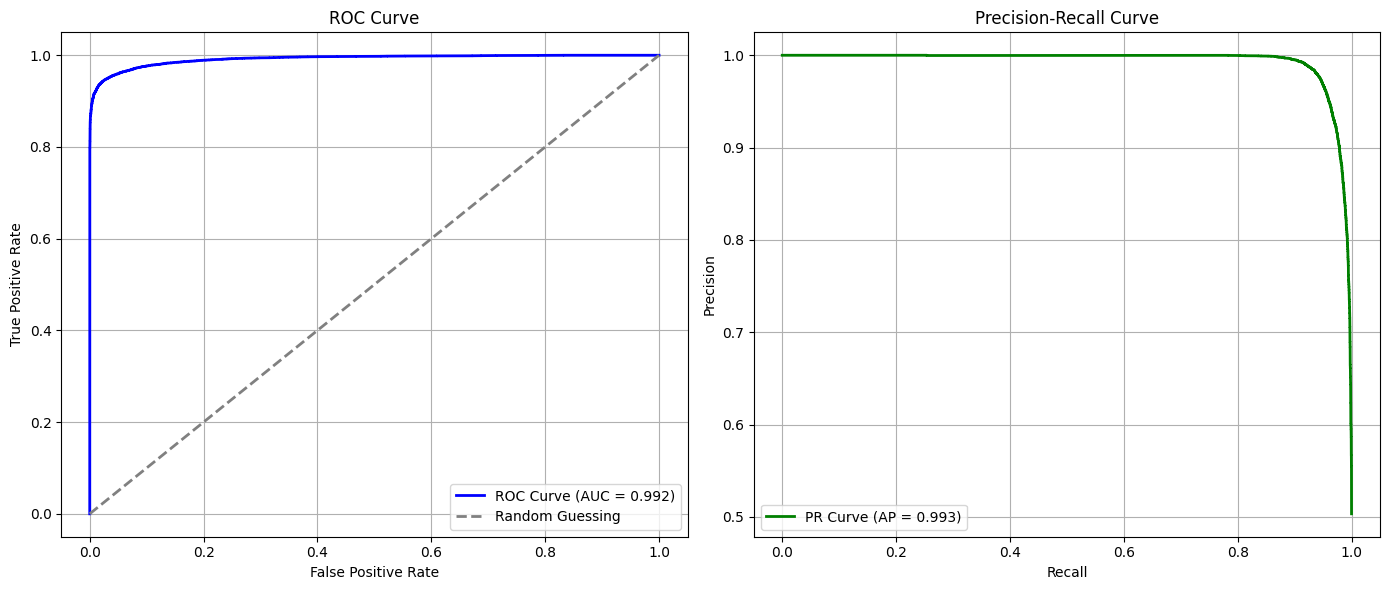

In [12]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay, average_precision_score
)

# Print evaluation metrics
print(
    f"""Accuracy : {round(accuracy_score(y_test, y_pred), 5)}
Precision: {round(precision_score(y_test, y_pred), 5)}
Recall   : {round(recall_score(y_test, y_pred), 5)}
F1-Score : {round(f1_score(y_test, y_pred), 5)}"""
)

# plot ROC and PR curves
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
ax[0].plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
ax[0].plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2, label="Random Guessing")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("ROC Curve")
ax[0].legend(loc="lower right")
ax[0].grid(True)

# plot PR curve
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap_score = average_precision_score(y_test, y_score)
ax[1].plot(recall, precision, color="green", lw=2, label=f"PR Curve (AP = {ap_score:.3f})")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision-Recall Curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
"""
overfitting

https://scikit-learn.org/stable/modules/learning_curve.html
"""